# Installation

With the help of docker we downloaded a neo4j image locally, and we started the container with the following command: 
```
docker run  --platform linux/amd64 -p7474:7474  -p7687:7687 -d --env  NEO4J_AUTH=neo4j/test neo4j:latest
```


# DB Connection 

We will use Python to connect to our database. 
For this reason we should install the neo4j package from PyPI

In [1]:
! pip3 install neo4j

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [5]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "test"), encrypted=False)

# Data Loading

First, we need to read our data from the file system, where they are save as .tsv files. The data were downloaded from
this url: https://snap.stanford.edu/data/act-mooc.html
We will use pandas in order to read our data

In [14]:

import pandas as pd

#Read data from .tsv files
actions = pd.read_csv('act-mooc/mooc_actions.tsv', sep='\t')
labels = pd.read_csv('act-mooc/mooc_action_labels.tsv', sep='\t')
features = pd.read_csv('act-mooc/mooc_action_features.tsv', sep='\t')

## Load Users

In [7]:
with driver.session() as session:

    for id in actions["USERID"].unique():
        result = session.run("Create (n:User) "
                        "SET n.id = $id "
                        "RETURN 'User:' + id(n)", id=int(id))
    

## Load Targets

In [8]:
    for id in actions["TARGETID"].unique():
        result = session.run("Create (n:Target) "
                        "SET n.id = $id "
                        "RETURN 'Target:' + id(n)", id=int(id))

## Load Actions

In order to load the actions to our graph database, we need to create a merged dataframe containing for each action its attributes

In [41]:
temp = actions.merge(labels, on=['ACTIONID'])
merged_actions =  temp.merge(features, on=['ACTIONID'])
merged_actions = merged_actions.head(1000)

In [42]:
#QUERY TO DELETE ALL RELATIONSHIPS: MATCH (n1)-[r]->() DELETE r
with driver.session() as session:
    for action in merged_actions.iterrows():
        result = session.run('''MATCH (a:User),(b:Target)
                             WHERE a.id = $userID AND b.id = $targetID
                             CREATE (a)-[r:ACTION{timestamp: $timestamp,
                             label: $label, feature0: $feaure0, feature1: $feaure1,
                             feature2: $feaure2, feature3: $feaure3}]->(b)
                             RETURN type(r)''', userID=int(action[1]["USERID"]),
                             targetID=int(action[1]["TARGETID"]),
                             timestamp=action[1]["TIMESTAMP"],
                             label=action[1]["LABEL"],
                             feaure0=action[1]["FEATURE0"],
                             feaure1=action[1]["FEATURE1"],
                             feaure2=action[1]["FEATURE2"],
                             feaure3=action[1]["FEATURE3"],
                            )
                             

# Graph Database Schema

Bellow we present a graphical representation of our Database Schema, of the first 100 edges.
We also present an example coordinate of the graph, having as n1 the User node, as n2 the Target node and as n3 the edge (action) between them.

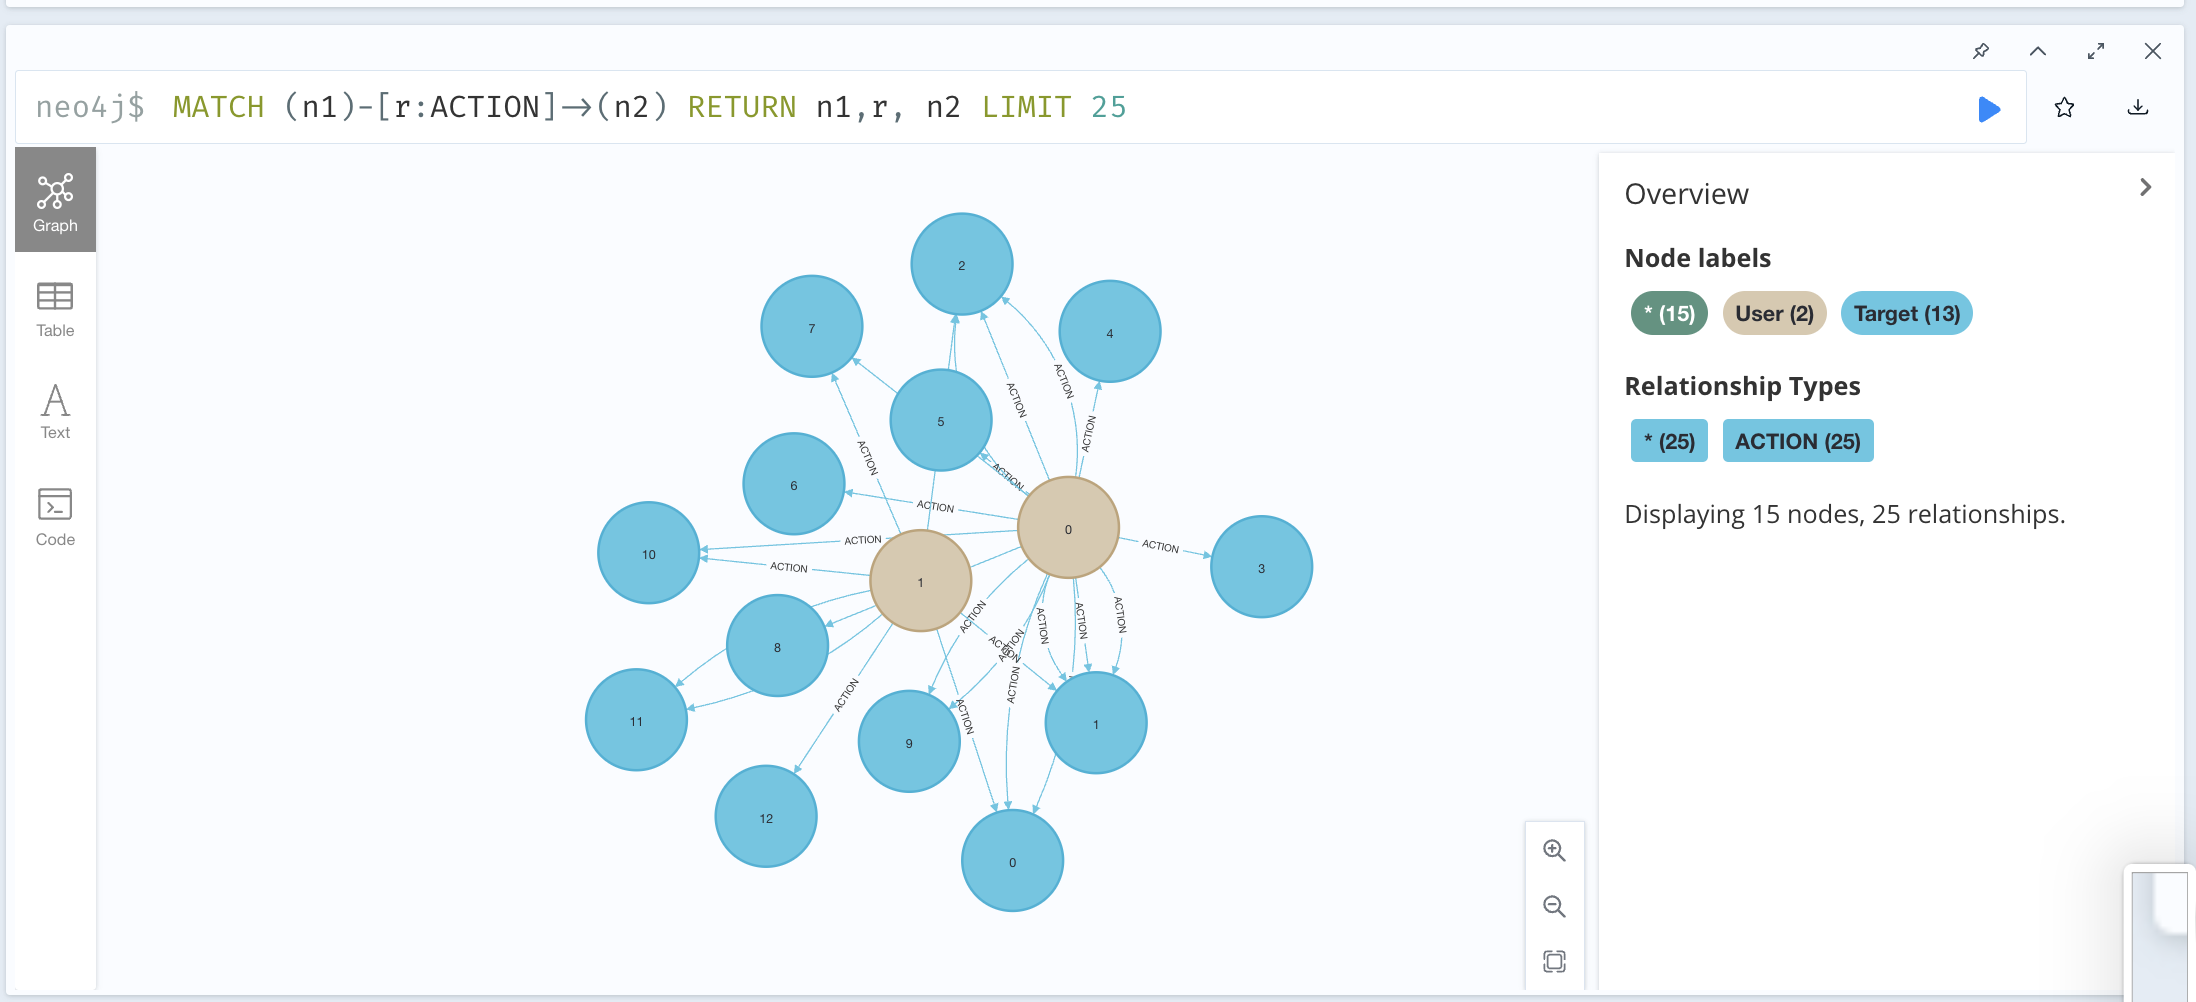

In [43]:
from IPython.display import Image
Image('img/schema.png') 

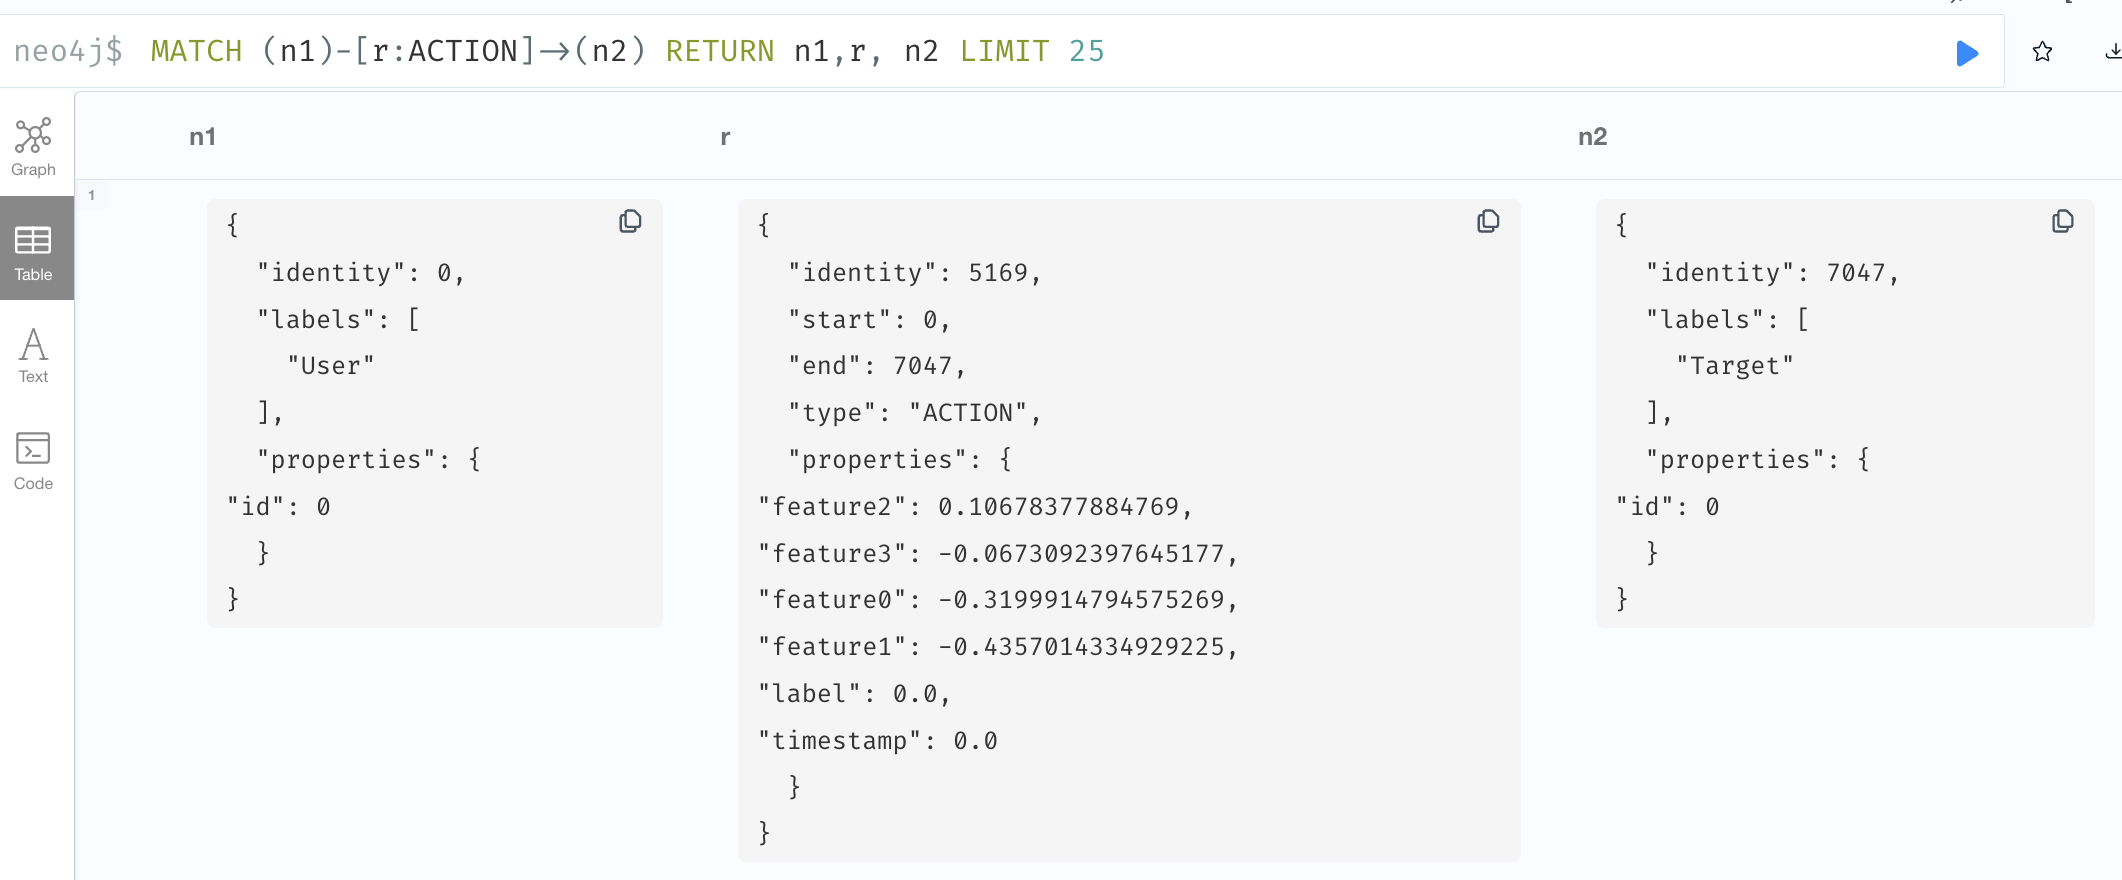

In [44]:
Image('img/example_table.png') 